# Summary
In this notebook we prepare the data for a fit, using a dataloader.
The sampled batch shoule have the shape `((batch_size, 12, 450), (batch_size,K))`, where the first element is the 12-leads data and the second is the targets, comprised of `K` different outcomes of each person.


In [1]:
import random
import torch
import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# device = torch.device("mps")
device = torch.device("cuda")


In [4]:
df = pd.read_csv('../data/combined_data/sample-of-10k.csv')

# 1st phase
train_metadata = pd.read_csv('../data/combined_data/train-metadata.csv', index_col=0)
validation_metadata = pd.read_csv('../data/combined_data/validation-metadata.csv', index_col=0)
test_metadata = pd.read_csv('../data/combined_data/test-metadata.csv', index_col=0)

# 2nd phase
additional_targets = pd.read_csv('../data/combined_data/additional-targets.csv', index_col=0)

# show
train_metadata.iloc[:5]

# train
df_train = train_metadata[['reading','outcome']].merge(df,
                                                       on='reading')

df_train.iloc[:5]

,reading,outcome,V1_0,V1_1,V1_2,V1_3,V1_4,V1_5,V1_6,V1_7,...,aVF_440,aVF_441,aVF_442,aVF_443,aVF_444,aVF_445,aVF_446,aVF_447,aVF_448,aVF_449


In [43]:
pd.set_option('display.max_columns', 100)

display(train_metadata.iloc[:5])
display(additional_targets.iloc[:5])


,reading,reading_date,Original_Index,Index,moh_death,reading_date_datetime,moh_death_datetime,delta_time,outcome
324163,427805,20/01/2008,2208,427805,NaN,2008-01-20,NaN,NaN,0
254526,356921,23/02/2010,39020,356921,4/1/19,2010-02-23,2019-04-01,3324.0,0
339871,428248,19/12/2015,39084,428248,NaN,2015-12-19,NaN,NaN,0
334067,440621,18/08/2017,35155,440621,NaN,2017-08-18,NaN,NaN,0
27651,32229,10/07/2019,22415,32229,NaN,2019-07-10,NaN,NaN,0


,Customer_CustID,Adjusted_ID,last_known_date,assumed_dead,approximate_death,test_group,DM,CVA,first_AF_in_home_ECG,first_AF_in_Dispatch,AF,IHD,s/p MI all,s/p CABG,CHF,s/p CPR,cpr_shl,key,Patient ID,merge_additional_targets_keys,reading,dates,Customer_BirthDate,Age_at_start,CVA_already,first_AF_in_home_ECG_already,first_AF_in_Dispatch_already,AF_already,IHD_already,s/p MI all_already,s/p CABG_already,CHF_already,s/p CPR_already,cpr_shl_already
0,11553.0,115535.0,3/7/2005,1.0,3/7/2005,dead,8/8/2001,NaN,12/6/1999,1/14/1994,8/8/2001,NaN,NaN,NaN,NaN,NaN,NaN,140739.0,11553.0,has additional targets and was found in index,140739,07/10/2003,1/1/25,65.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,11553.0,115535.0,3/7/2005,1.0,3/7/2005,dead,8/8/2001,NaN,12/6/1999,1/14/1994,8/8/2001,NaN,NaN,NaN,NaN,NaN,NaN,275647.0,11553.0,has additional targets and was found in index,275647,07/10/2003,1/1/25,65.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,11553.0,115535.0,3/7/2005,1.0,3/7/2005,dead,8/8/2001,NaN,12/6/1999,1/14/1994,8/8/2001,NaN,NaN,NaN,NaN,NaN,NaN,342840.0,11553.0,has additional targets and was found in index,342840,05/11/2002,1/1/25,65.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,11553.0,115535.0,3/7/2005,1.0,3/7/2005,dead,8/8/2001,NaN,12/6/1999,1/14/1994,8/8/2001,NaN,NaN,NaN,NaN,NaN,NaN,397704.0,11553.0,has additional targets and was found in index,397704,24/07/2001,1/1/25,65.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,11553.0,115535.0,3/7/2005,1.0,3/7/2005,dead,8/8/2001,NaN,12/6/1999,1/14/1994,8/8/2001,NaN,NaN,NaN,NaN,NaN,NaN,397705.0,11553.0,has additional targets and was found in index,397705,31/10/2001,1/1/25,65.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
train_metadata.merge(additional_targets,
                     on='reading',
                     indicator=True,
                     how='outer'
                     )['_merge'].value_counts()

_merge
both          278591
right_only    184850
left_only         58
Name: count, dtype: int64

In [49]:
additional_targets[['dates','AF','AF_already']][pd.notna(additional_targets['AF'])]

,dates,AF,AF_already
0,07/10/2003,8/8/2001,1.0
1,07/10/2003,8/8/2001,1.0
2,05/11/2002,8/8/2001,1.0
3,24/07/2001,8/8/2001,0.0
4,31/10/2001,8/8/2001,1.0
...,...,...,...
455926,30/10/2001,6/14/2001,NaN
455927,19/04/2002,6/14/2001,NaN
455928,30/10/2001,6/14/2001,NaN
455933,11/04/2005,12/21/2004,NaN


# Recreate Additional Targets
it seems that because `dates` are in `DD-MM-YYYY` format while `AF` is in `M/D/YYYY` format, we have some mislabeling issues. In this part we relabel observations

In [53]:
# utils
def diff2(date1, date2):
    """
    difference (in days) between two dates, assuming date2 is the last.
    date1 and date2 are strings.
    """
    from datetime import date
    
    try:
        d1,m1,y1 = date1.split('/')
        m2,d2,y2 = date2.split('/')

        date1 = date(int(y1),int(m1),int(d1))
        date2 = date(int(y2),int(m2),int(d2))
        ret = (date2-date1).days
    except:
        ret = None
    
    return ret

additional_targets['AF_already_temp2'] = [diff2(additional_targets['dates'][j], additional_targets['AF'][j]) for j in range(len(additional_targets))]
additional_targets['AF_already2'] = (additional_targets['AF_already_temp2']<0).astype(int)
additional_targets['AF_already2'][pd.isna(additional_targets['AF'])]=np.nan 
print(additional_targets['AF_already2'].value_counts())



AF_already2
1.0    114559
0.0     60685
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1671299674.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets['AF_already2'][pd.isna(additional_targets['AF'])]=np.nan


In [54]:
pd.crosstab(additional_targets['AF_already'],
            additional_targets['AF_already2'])

AF_already2,0.0,1.0
AF_already,,
0.0,19631,1808
1.0,2049,42124


In [60]:
additional_targets[(additional_targets['AF_already'] != additional_targets['AF_already2']) & (pd.notna(additional_targets['AF']))][['dates','AF', 'AF_already', 'AF_already2']]

,dates,AF,AF_already,AF_already2
8,NaN,4/21/1997,NaN,0.0
9,22/02/2012,6/18/2010,NaN,1.0
10,12/11/2013,6/18/2010,NaN,1.0
11,13/11/2013,6/18/2010,NaN,1.0
12,29/06/2010,6/18/2010,NaN,1.0
...,...,...,...,...
455926,30/10/2001,6/14/2001,NaN,1.0
455927,19/04/2002,6/14/2001,NaN,1.0
455928,30/10/2001,6/14/2001,NaN,1.0
455933,11/04/2005,12/21/2004,NaN,1.0


In [61]:
def diff2(date1, date2):
    """
    difference (in days) between two dates, assuming date2 is the last.
    date1 and date2 are strings.
    """
    from datetime import date
    
    try:
        d1,m1,y1 = date1.split('/')
        m2,d2,y2 = date2.split('/')

        date1 = date(int(y1),int(m1),int(d1))
        date2 = date(int(y2),int(m2),int(d2))
        ret = (date2-date1).days
    except:
        ret = None
    
    return ret

for var in ['DM', 'CVA', 'first_AF_in_home_ECG', 'first_AF_in_Dispatch', 'AF', 'IHD', 's/p MI all','s/p CABG', 'CHF', 's/p CPR', 'cpr_shl']:

    additional_targets[f'{var}_already_temp'] = [diff2(additional_targets['dates'][j], additional_targets[var][j]) for j in range(len(additional_targets))]
    additional_targets[f'{var}_already'] = (additional_targets[f'{var}_already_temp']<0).astype(int)
    additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan 
    print(additional_targets[f'{var}_already'].value_counts())



/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


DM_already
1.0    68283
0.0    50144
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


CVA_already
1.0    31356
0.0    27660
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


first_AF_in_home_ECG_already
1.0    141786
0.0     67490
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


first_AF_in_Dispatch_already
1.0    131996
0.0     62442
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


AF_already
1.0    114559
0.0     60685
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


IHD_already
1.0    219403
0.0     27495
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


s/p MI all_already
1.0    144849
0.0     18143
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


s/p CABG_already
1.0    72394
0.0     7894
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


CHF_already
1.0    41354
0.0    35005
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


s/p CPR_already
1.0    10220
0.0     1643
Name: count, dtype: int64
cpr_shl_already
0.0    16390
1.0     2011
Name: count, dtype: int64


/var/folders/t5/rmhnhv8d39v2fgyk_bv5fx7h0000gn/T/ipykernel_26322/1355424825.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  additional_targets[f'{var}_already'][pd.isna(additional_targets[var])]=np.nan


In [84]:
additional_targets_processed = (
    additional_targets[['dates','reading']+[x for x in additional_targets.columns if 'already' in x and '_temp' not in x]].
    rename({x:x.replace('_already','').
            replace('s/p','sp').
            replace(' ','_') for x in additional_targets.columns if '_already' in x},axis=1)
) 
for x in additional_targets_processed.columns: 
    if x not in ['dates', 'reading']:
        additional_targets_processed[x]=additional_targets_processed[x].fillna(0)
        print(x)
        display(additional_targets_processed[x].value_counts(normalize=True))


# additional_targets_processed.to_csv('./data/combined_data/targets.csv')
    

CVA


CVA
0.0    0.932341
1.0    0.067659
Name: proportion, dtype: float64

first_AF_in_home_ECG


first_AF_in_home_ECG
0.0    0.694058
1.0    0.305942
Name: proportion, dtype: float64

first_AF_in_Dispatch


first_AF_in_Dispatch
0.0    0.715183
1.0    0.284817
Name: proportion, dtype: float64

AF


AF
0.0    0.752808
1.0    0.247192
Name: proportion, dtype: float64

IHD


IHD
0.0    0.526578
1.0    0.473422
Name: proportion, dtype: float64

sp_MI_all


sp_MI_all
0.0    0.687449
1.0    0.312551
Name: proportion, dtype: float64

sp_CABG


sp_CABG
0.0    0.84379
1.0    0.15621
Name: proportion, dtype: float64

CHF


CHF
0.0    0.910767
1.0    0.089233
Name: proportion, dtype: float64

sp_CPR


sp_CPR
0.0    0.977948
1.0    0.022052
Name: proportion, dtype: float64

cpr_shl


cpr_shl
0.0    0.995661
1.0    0.004339
Name: proportion, dtype: float64

DM2


DM2
0.0    0.852661
1.0    0.147339
Name: proportion, dtype: float64

AF2


AF2
0.0    0.752808
1.0    0.247192
Name: proportion, dtype: float64

DM


DM
0.0    0.852661
1.0    0.147339
Name: proportion, dtype: float64

# Merge with Death Outcome

In [91]:
train_metadata['sample'] = 'train'
validation_metadata['sample'] = 'validation'
test_metadata['sample'] = 'test'

death_metadata = pd.concat([train_metadata,validation_metadata,test_metadata],axis=0, ignore_index=True)
death_metadata[['reading','outcome']].merge(additional_targets_processed,
                                            on='reading',
                                            how='outer',
                                            indicator=True)['_merge'].value_counts()

_merge
both          395772
right_only     67669
left_only        180
Name: count, dtype: int64

In [94]:
additional_targets_processed.columns

Index(['dates', 'reading', 'CVA', 'first_AF_in_home_ECG',
       'first_AF_in_Dispatch', 'AF', 'IHD', 'sp_MI_all', 'sp_CABG', 'CHF',
       'sp_CPR', 'cpr_shl', 'DM2', 'AF2', 'DM'],
      dtype='object')

In [101]:
os.listdir('../data/combined_data/')

'/Users/davidharar/Documents/School/thesis/downstream_classification/notebooks'

In [102]:
death_metadata = pd.concat([train_metadata,validation_metadata,test_metadata],axis=0, ignore_index=True)

metadata = (
    death_metadata[['sample','reading','outcome']].merge(additional_targets_processed,
                                            on='reading',
                                            how='inner')[['sample','reading', 'dates','outcome', 'CVA', 'first_AF_in_home_ECG',
                                                          'first_AF_in_Dispatch', 'AF', 'IHD', 'sp_MI_all', 'sp_CABG', 'CHF',
                                                          'sp_CPR', 'cpr_shl', 'DM2', 'AF2', 'DM']].
                                                          rename({'outcome':'one_year_until_death'},axis=1)

)
# metadata.to_csv('../data/combined_data/metadata.csv')
metadata

,sample,reading,dates,one_year_until_death,CVA,first_AF_in_home_ECG,first_AF_in_Dispatch,AF,IHD,sp_MI_all,sp_CABG,CHF,sp_CPR,cpr_shl,DM2,AF2,DM
0,train,427805,20/01/2008,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,train,356921,23/02/2010,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,train,428248,19/12/2015,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train,440621,18/08/2017,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,train,32229,10/07/2019,0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395767,test,387849,01/04/2001,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395768,test,395752,23/04/2012,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395769,test,434377,03/09/2012,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395770,test,384590,10/09/2000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
metadata['reading'][0]

427805

In [125]:
signal_index = 427805
targets = ['one_year_until_death', 'AF']
metadata[metadata['reading'] == signal_index][targets].values


array([[0., 1.]])

# Save indivudual signals


In [2]:
os.listdir('../data/combined_data/')

['additional-targets.csv',
 'metadata_only_existant_readings.csv',
 'metadata_sample_for_testing_1.csv',
 'metadata.csv',
 'metadata_sample_for_testing_0.csv',
 'train-metadata.csv',
 'metadata_sample_for_testing_balanced_by_DM.csv',
 'validation-metadata.csv',
 'All_leads_2909_with_NAs_relevant_readings.csv',
 'metadata_balanced_by_death.csv',
 'test-metadata.csv',
 'meta_data_w_Customer_CustID.csv',
 'metadata_sample_for_testing-flipped-labels.csv',
 'metadata_sample_for_testing.csv',
 'sample-of-10k.csv',
 'metadata_only_existant_readings_09042023.csv']

In [3]:
_ = (
    pd.read_csv('../data/combined_data/All_leads_2909_with_NAs_relevant_readings.csv',nrows=5, index_col=0)
)
indices = _['reading'].values
chunk = _.drop([x for x in _.columns if 'index' in x] + ['reading'],axis=1)
chunk.shape

(5, 5400)

In [4]:
cols = [[f'{lead}_{j}' for j in range(450)] for lead in ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']]
cols = [item for sublist in cols for item in sublist]
chunk[cols]

,LI_0,LI_1,LI_2,LI_3,LI_4,LI_5,LI_6,LI_7,LI_8,LI_9,...,V6_440,V6_441,V6_442,V6_443,V6_444,V6_445,V6_446,V6_447,V6_448,V6_449
0,0.181759,0.170171,0.165855,0.173997,0.190517,0.205395,0.210581,0.205953,0.200640,0.200825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.459594,0.447277,0.439849,0.433463,0.421895,0.408265,0.400133,0.395509,0.387051,0.372442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.409843,0.418978,0.417481,0.402148,0.378215,0.352438,0.329572,0.321040,0.348614,0.428915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.369911,0.389002,0.401170,0.402060,0.390232,0.368503,0.345600,0.332183,0.332401,0.340534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.090338,0.075212,0.065811,0.066344,0.076146,0.088291,0.093732,0.089125,0.078993,0.068513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
indices = pd.read_csv('../data/combined_data/All_leads_2909_with_NAs_relevant_readings.csv',usecols=['reading'])
indices.iloc[:10]

,reading
0,2690
1,35248
2,101
3,41288
4,22019
5,14347
6,22784
7,5801
8,15063
9,28557


In [55]:
indices['reading'].max()

561330

In [7]:
CHUNKSIZE = 1000
cols = [[f'{lead}_{j}' for j in range(450)] for lead in ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6']]
cols = [item for sublist in cols for item in sublist]
destination_folder = '../data/individual-signals/'

# with pd.read_csv('../data/combined_data/sample-of-10k.csv', chunksize=CHUNKSIZE) as reader:
with pd.read_csv('../data/combined_data/All_leads_2909_with_NAs_relevant_readings.csv', chunksize=CHUNKSIZE, index_col=0) as reader:
    for chunk in tqdm(reader, desc='Saving files'):
        indices = chunk['reading'].values
        chunk = chunk.drop([x for x in _.columns if 'index' in x],axis=1)
        n_chunk = len(chunk)
        X = chunk[cols].values.reshape((n_chunk,12,450))
        for i in tqdm(range(CHUNKSIZE)):
            np.save(destination_folder+f'{indices[i]}.npy', X[i])




100%|██████████| 1000/1000 [00:00<00:00, 4419.55it/s]
Saving files: 17it [00:18,  1.08s/it]/home/david/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (2257) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
100%|██████████| 1000/1000 [00:00<00:00, 4275.98it/s]
Saving files: 102it [01:59,  1.14s/it]/home/david/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (4061) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
100%|██████████| 1000/1000 [00:00<00:00, 4269.28it/s]
Saving files: 124it [02:24,  1.14s/it]/home/david/anaconda3/lib/python3.9/site-packages/tqdm/std.py:1195: DtypeWarning: Columns (4061) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
100%|██████████| 1000/1000 [00:00<00:00, 4280.47it/s]
Saving files: 167it [03:41,  1.35s/it]/home/david/anaconda3/lib/python3.9/site-packages/t

IndexError: index 733 is out of bounds for axis 0 with size 733

In [8]:
len(os.listdir('../data/individual-signals/'))

408733

In [47]:
len(os.listdir('../data/individual-signals/'))

408734

# Fix Metadata and Readings
- 5% is missing uniformly. I remove these examples.

In [58]:
metadata = pd.read_csv('./data/combined_data/metadata.csv',index_col=0)
metadata.iloc[:5]

,sample,reading,dates,one_year_until_death,CVA,first_AF_in_home_ECG,first_AF_in_Dispatch,AF,IHD,sp_MI_all,sp_CABG,CHF,sp_CPR,cpr_shl,DM2,AF2,DM
0,train,427805,20/01/2008,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,train,356921,23/02/2010,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,train,428248,19/12/2015,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train,440621,18/08/2017,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,train,32229,10/07/2019,0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [62]:
pd.crosstab(
               metadata.merge(indices,
                        on = 'reading',
                        how='outer',
                        indicator=True)['_merge'],
               metadata.merge(indices,
                        on = 'reading',
                        how='outer',
                        indicator=True)['sample']
                        , normalize='columns')
pd.crosstab(
               metadata.merge(indices,
                        on = 'reading',
                        how='outer',
                        indicator=True)['_merge'],
               metadata.merge(indices,
                        on = 'reading',
                        how='outer',
                        indicator=True)['sample']
                        )
               

sample,test,train,validation
_merge,,,
left_only,2848,13782,2714
both,57840,264809,53779


In [63]:
57840+264809+53779

376428

In [66]:
metadata = metadata[metadata['reading'].isin(indices['reading'].tolist())].reset_index(drop=True)
metadata.to_csv('./data/combined_data/metadata_only_existant_readings.csv')

# Data Loader


In [48]:
import os
os.chdir('../')
os.getcwd()

from dataloader.DataLoader import *


In [49]:
# --------------------------------
# Usage example
# --------------------------------

train_generator = DataGenerator(
    metadata_file_path= './data/combined_data/metadata.csv',   # path to metadata file
    data_folder_path = './data/individual-signals/',     # path to individual signals
    sample='train',               # sample we want to create a generator to. Either train, validation or test
    targets=['AF'],             # list of targets we want train on
    batch_size=4,           # batch size
    shuffle=True,       # Whether to shuffle the list of IDs at the end of each epoch.
    fillna=0
                 )

# X,y = train_generator.__getitem__(1224)
X,y = train_generator.__getitem__(122)
print(X.shape, y.shape)
X,y




(4, 12, 450) (4, 1, 1)


(array([[[0.07035693, 0.07568277, 0.07440537, ..., 0.2962655 ,
          0.29798081, 0.30880839],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.54670978, 0.57286823, 0.59475433, ..., 0.40395203,
          0.4055782 , 0.41138153],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.29788438, 0.30490081, 0.30807252, ..., 0.41146168,
          0.41332993, 0.4153182 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.09605672, 0.08102025, 0.07305227, ..., 0.10060301,
          0.10097296, 0.10191689],
         [0.17137337, 0.16570022, 0.15928345, ..., 0.18195498,
          0.18496174, 0.18699796],
         [0.85849231, 0.8789722 , 0.88437637, ..., 0.8670979 ,
          0.86805067, 0.86900862],
         ...,
         [0.51232884, 0.51460549, 0.51034897, ..., 0.48689366,
          0.49303684, 0.

In [183]:
y

array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]]])

In [185]:
X[0].shape

(12, 450)

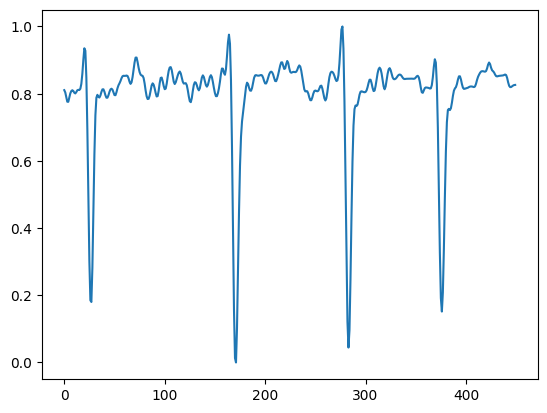

In [186]:
plt.plot(X[0][0])

# Model

In [1]:
import os
os.chdir('../')
os.listdir()



['.DS_Store',
 'Summary.md',
 'utils',
 'models',
 'modeling',
 'executors',
 'configs',
 'main.py',
 'data',
 'notebooks',
 'plots',
 'dataloader']

In [50]:
from executors.train_on_local_machine_mps import *


/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
train_generator = DataGenerator(
    metadata_file_path= './data/combined_data/metadata.csv',   # path to metadata file
    data_folder_path = './data/individual-signals/',     # path to individual signals
    sample='train',               # sample we want to create a generator to. Either train, validation or test
    targets=['AF'],             # list of targets we want train on
    batch_size=4,           # batch size
    shuffle=True       # Whether to shuffle the list of IDs at the end of each epoch.
                 )

X,y = train_generator.__getitem__(1224)
print(X.shape, y.shape)
X,y


(4, 12, 450) (4, 1, 1)


(array([[[0.8105132 , 0.80375487, 0.78977823, ..., 0.82434064,
          0.825726  , 0.8260739 ],
         [0.64676106, 0.63912654, 0.6361029 , ..., 0.5892875 ,
          0.5898527 , 0.5920997 ],
         [0.367957  , 0.36431572, 0.36054474, ..., 0.38270366,
          0.38431332, 0.3897444 ],
         ...,
         [0.12485901, 0.12692589, 0.12964651, ..., 0.15163463,
          0.14717524, 0.13836902],
         [0.90467817, 0.91214657, 0.92021906, ..., 0.87284875,
          0.877367  , 0.8815266 ],
         [0.4706599 , 0.43827498, 0.39946982, ..., 0.4625186 ,
          0.47015795, 0.5034792 ]],
 
        [[0.81004155, 0.8148542 , 0.811478  , ..., 0.7389775 ,
          0.7345119 , 0.7278662 ],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [0.4173252 , 0.40385526, 0.39333266, ..., 0.4572741 ,
          0.45874   , 0.46497807],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,   

In [19]:
X = np.float32(np.transpose(X, axes=(2,0,1)))
X.shape

(450, 4, 12)

In [20]:
y = np.float32(np.transpose(y, axes=(2,0,1)))

X = torch.from_numpy(X)
y = torch.from_numpy(y)

X = X.to(device)
y = y.to(device)

In [22]:
X.shape

torch.Size([450, 4, 12])

In [33]:
X

tensor([[[0.8105, 0.6468, 0.3680,  ..., 0.1249, 0.9047, 0.4707],
         [0.8100,    nan, 0.4173,  ...,    nan,    nan,    nan],
         [0.7965, 0.6424, 0.2659,  ..., 0.3052, 0.6624,    nan],
         [0.3088, 0.5482, 0.3132,  ..., 0.2249,    nan,    nan]],

        [[0.8038, 0.6391, 0.3643,  ..., 0.1269, 0.9121, 0.4383],
         [0.8149,    nan, 0.4039,  ...,    nan,    nan,    nan],
         [0.7987, 0.6384, 0.2621,  ..., 0.3172, 0.6544,    nan],
         [0.3224, 0.5570, 0.3040,  ..., 0.2651,    nan,    nan]],

        [[0.7898, 0.6361, 0.3605,  ..., 0.1296, 0.9202, 0.3995],
         [0.8115,    nan, 0.3933,  ...,    nan,    nan,    nan],
         [0.8011, 0.6362, 0.2591,  ..., 0.3319, 0.6463,    nan],
         [0.3306, 0.5759, 0.3041,  ..., 0.2968,    nan,    nan]],

        ...,

        [[0.8243, 0.5893, 0.3827,  ..., 0.1516, 0.8728, 0.4625],
         [0.7390,    nan, 0.4573,  ...,    nan,    nan,    nan],
         [0.7189, 0.6884, 0.3061,  ..., 0.3748, 0.6026,    nan],
     

In [32]:
sft = nn.Sigmoid()
sft(torch.tensor([0.8243, 0.5893, 0.3827]))

tensor([0.6951, 0.6432, 0.5945])

In [4]:
os.listdir('./configs/')

['.DS_Store', 'death']

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


********************
* Experiment ['1'] *
********************
Configurations:
{'seed': 123, 'metadata_file_path': './data/combined_data/metadata_sample_for_testing.csv', 'data_folder_path': './data/individual-signals/', 'fillna': 0, 'batch_size': 32, 'n_epochs': 30, 'targets': ['AF'], 'input_dimension': 12, 'hidden_dimmension': 64, 'attention_heads': None, 'encoder_number_of_layers': 8, 'dropout': 0.4, 'clip': 1, 'positional_encodings': False, 'saving_path': './models/exp1'}

Starting Experiment


training using device: mps


64 1
The model has 694,530 trainable parameters
TransformerEncoderDownstream(
  (project_input): Linear(in_features=12, out_features=64, bias=True)
  (encoder): Linear(in_features=12, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_

Within epoch loss (validation) 0.58178: 100%|██████████| 81/81 [00:14<00:00,  5.40it/s]


---------------------------------------------
Epoch: 01 | Time: 4m 9s
	Train Loss: 0.674
	 Val. Loss: 0.582
	 Best Val. Loss: 0.582
---------------------------------------------


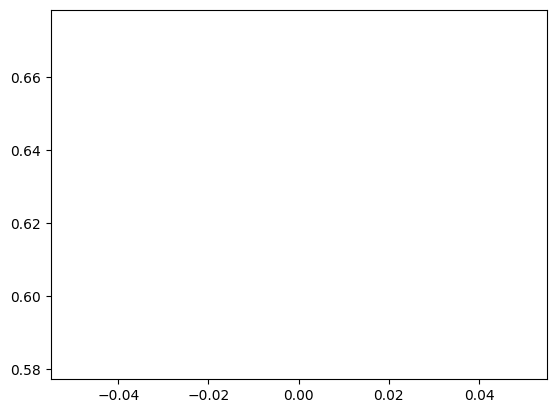

Within epoch loss (validation) 0.57938: 100%|██████████| 81/81 [00:15<00:00,  5.28it/s]


---------------------------------------------
Epoch: 02 | Time: 4m 11s
	Train Loss: 0.571
	 Val. Loss: 0.579
	 Best Val. Loss: 0.579
---------------------------------------------


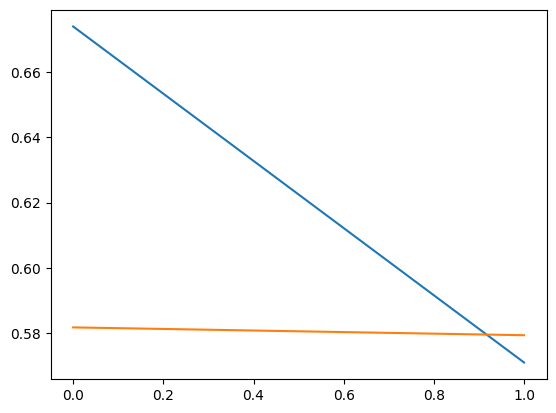

Within epoch loss (validation) 0.57859: 100%|██████████| 81/81 [00:15<00:00,  5.12it/s]


---------------------------------------------
Epoch: 03 | Time: 4m 18s
	Train Loss: 0.576
	 Val. Loss: 0.579
	 Best Val. Loss: 0.579
---------------------------------------------


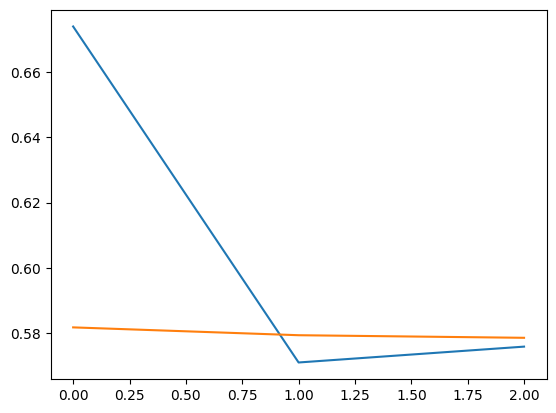

Within epoch loss (training) 0.56546:   4%|▎         | 15/416 [00:08<03:54,  1.71it/s]


KeyboardInterrupt: 

In [1]:
import os
import re
import yaml

# make sure we're in the correct directory
os.chdir('/Users/davidharar/Documents/School/thesis/downstream_classification')

# import trainer
from executors.train_on_local_machine_mps import trainer

# import yaml file. Later, loop over configs
config_file_name = 'death/exp1.yml'

with open('./configs/'+config_file_name,'r') as f:
    config = yaml.safe_load(f)['config']

experiment_ind = re.findall(r'\d+', config_file_name)
print(len(f'* Experiment {experiment_ind} *')*'*')
print(f'* Experiment {experiment_ind} *')
print(len(f'* Experiment {experiment_ind} *')*'*')
print('Configurations:')
print(config)
print('')
# run
print('Starting Experiment')
trainer(**config)


In [19]:
import pandas as pd
metadata = pd.read_csv('./data/combined_data/metadata_only_existant_readings.csv',index_col=0)
metadata.sample(frac=0.1).reset_index(drop=True).to_csv('./data/combined_data/metadata_sample_for_testing.csv')

In [20]:
metadata.sample(frac=0.1).shape

(37643, 17)

# Check if our model works

In [5]:
import torch
# Create a tensor
tensor = torch.randn(3, 12,2)
# View the tensor
tensor.view(3, -1).shape

torch.Size([3, 24])

In [7]:
import numpy as np
y = np.zeros((32,1,1))
.shape

(32, 1)

In [14]:
tensor = tensor.to('mps')
tensor = tensor.to('cpu')
tensor

tensor([[[-0.2807,  1.9438],
         [-0.6101,  0.4325],
         [ 2.2085, -0.5685],
         [-0.9821, -1.5713],
         [ 1.2341, -0.2183],
         [ 1.1544, -0.9379],
         [ 0.3843,  0.6942],
         [ 0.2224, -0.3526],
         [ 1.9856, -0.0361],
         [-0.7600, -0.8015],
         [-2.3494, -0.9026],
         [-1.1356, -2.1140]],

        [[ 1.4608, -0.4323],
         [ 1.4530,  0.2246],
         [-0.4961, -0.5755],
         [-1.1798, -1.9698],
         [-0.5196, -0.6470],
         [ 0.2018,  0.6569],
         [-0.3891, -0.5130],
         [ 0.9166,  0.2833],
         [-0.2820,  0.0979],
         [ 1.2233,  0.3268],
         [-0.0995,  1.6912],
         [-0.0221,  0.2057]],

        [[ 0.0969,  0.7337],
         [ 1.9527,  0.3254],
         [-0.1630,  0.1649],
         [-1.5073,  0.9341],
         [ 0.8732,  0.8087],
         [-0.6168,  1.2667],
         [-0.1089,  0.7629],
         [ 0.0067, -1.4230],
         [ 0.4968,  1.4763],
         [ 1.3571, -0.2813],
         [

In [15]:
metadata

NameError: name 'metadata' is not defined

In [18]:
import pandas as pd
metadata = pd.read_csv('./data/combined_data/metadata_only_existant_readings.csv',index_col=0)
metadata.describe()

,reading,one_year_until_death,CVA,first_AF_in_home_ECG,first_AF_in_Dispatch,AF,IHD,sp_MI_all,sp_CABG,CHF,sp_CPR,cpr_shl,DM2,AF2,DM
count,376428.000000,376428.000000,376428.000000,376428.000000,376428.000000,376428.00000,376428.000000,376428.000000,376428.000000,376428.000000,376428.000000,376428.000000,376428.000000,376428.00000,376428.000000
mean,310002.560338,0.021151,0.068797,0.304605,0.280747,0.24750,0.484520,0.319745,0.157432,0.091537,0.022477,0.003727,0.152661,0.24750,0.152661
std,152335.458628,0.143889,0.253108,0.460241,0.449365,0.43156,0.499761,0.466378,0.364209,0.288371,0.148229,0.060937,0.359661,0.43156,0.359661
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,211376.750000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,323959.500000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,437304.250000,0.000000,0.000000,1.000000,1.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,561330.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [17]:
metadata

,sample,reading,dates,one_year_until_death,CVA,first_AF_in_home_ECG,first_AF_in_Dispatch,AF,IHD,sp_MI_all,sp_CABG,CHF,sp_CPR,cpr_shl,DM2,AF2,DM
0,train,427805,20/01/2008,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,train,356921,23/02/2010,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,train,428248,19/12/2015,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train,440621,18/08/2017,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,train,32229,10/07/2019,0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376423,test,387849,01/04/2001,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
376424,test,395752,23/04/2012,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
376425,test,434377,03/09/2012,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
376426,test,384590,10/09/2000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size())


torch.Size([128, 30])


In [58]:
N=32;C=16;L=450
in_channels = C
out_channels = 2
input = torch.randn(N,C,L)
print('input shape:', input.shape)
conv1d = nn.Conv1d(in_channels,out_channels,128)
# padding

x = conv1d(input)
padding_size = 450-x.shape[-1]
paddings = (int(np.floor(padding_size/2)),int(np.ceil(padding_size/2)))
F.pad(x, paddings).shape, x.shape



input shape: torch.Size([32, 16, 450])


(torch.Size([32, 2, 450]), torch.Size([32, 2, 323]))

In [55]:
paddings

(63.0, 64.0)

In [59]:
metadata_sample = pd.read_csv('./data/combined_data/metadata_sample_for_testing.csv',index_col=0)
metadata_sample['DM'].value_counts()

DM
0.0    31964
1.0     5679
Name: count, dtype: int64

In [60]:
metadata_sample['DM'].value_counts(normalize=True)

DM
0.0    0.849135
1.0    0.150865
Name: proportion, dtype: float64